In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 4.2 MB/s 
     |████████████████████████████████| 6.6 MB 58.3 MB/s 
     |████████████████████████████████| 596 kB 72.8 MB/s 
     |████████████████████████████████| 101 kB 12.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
!pip install pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 585 kB 4.1 MB/s 
     |████████████████████████████████| 419 kB 82.1 MB/s 
     |████████████████████████████████| 140 kB 90.2 MB/s 
     |████████████████████████████████| 1.1 MB 69.1 MB/s 
     |████████████████████████████████| 271 kB 86.0 MB/s 
     |████████████████████████████████| 144 kB 88.8 MB/s 
     |████████████████████████████████| 94 kB 4.0 MB/s 


In [ ]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import torch
import torch.nn as nn
from torchvision import ops
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
import pytorch_lightning as pl
from torchmetrics.functional import accuracy, auroc, f1_score
#from pytorch_lightning.metrics.functional import f1, auroc
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
%config InlineBackend.figure_format='retina'
RANDOM_SEED = 42
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
pl.seed_everything(RANDOM_SEED)

Global seed set to 42


42

# Data

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
df = pd.read_csv("/content/gdrive/MyDrive/Capstone/data/H_section_2years_final_onehot.csv",index_col=0) # 파일 업로드
df = df.rename(columns={'patent_abstract_y':'patent_abstract'})
df.head()

,patent_number,patent_abstract,H01B,H01C,H01F,H01G,H01H,H01J,H01K,H01L,...,H04S,H04T,H04W,H05B,H05C,H05F,H05G,H05H,H05K,H99Z
0,10524408,The present disclosure includes an agricultura...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10524426,A method of stimulating plant growth in a cont...,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,10524504,"An exemplary atomizer includes a shell, a liqu...",0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,10524505,An electronic vaping device includes a cartomi...,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,10524508,An aerosol delivery device is provided that in...,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


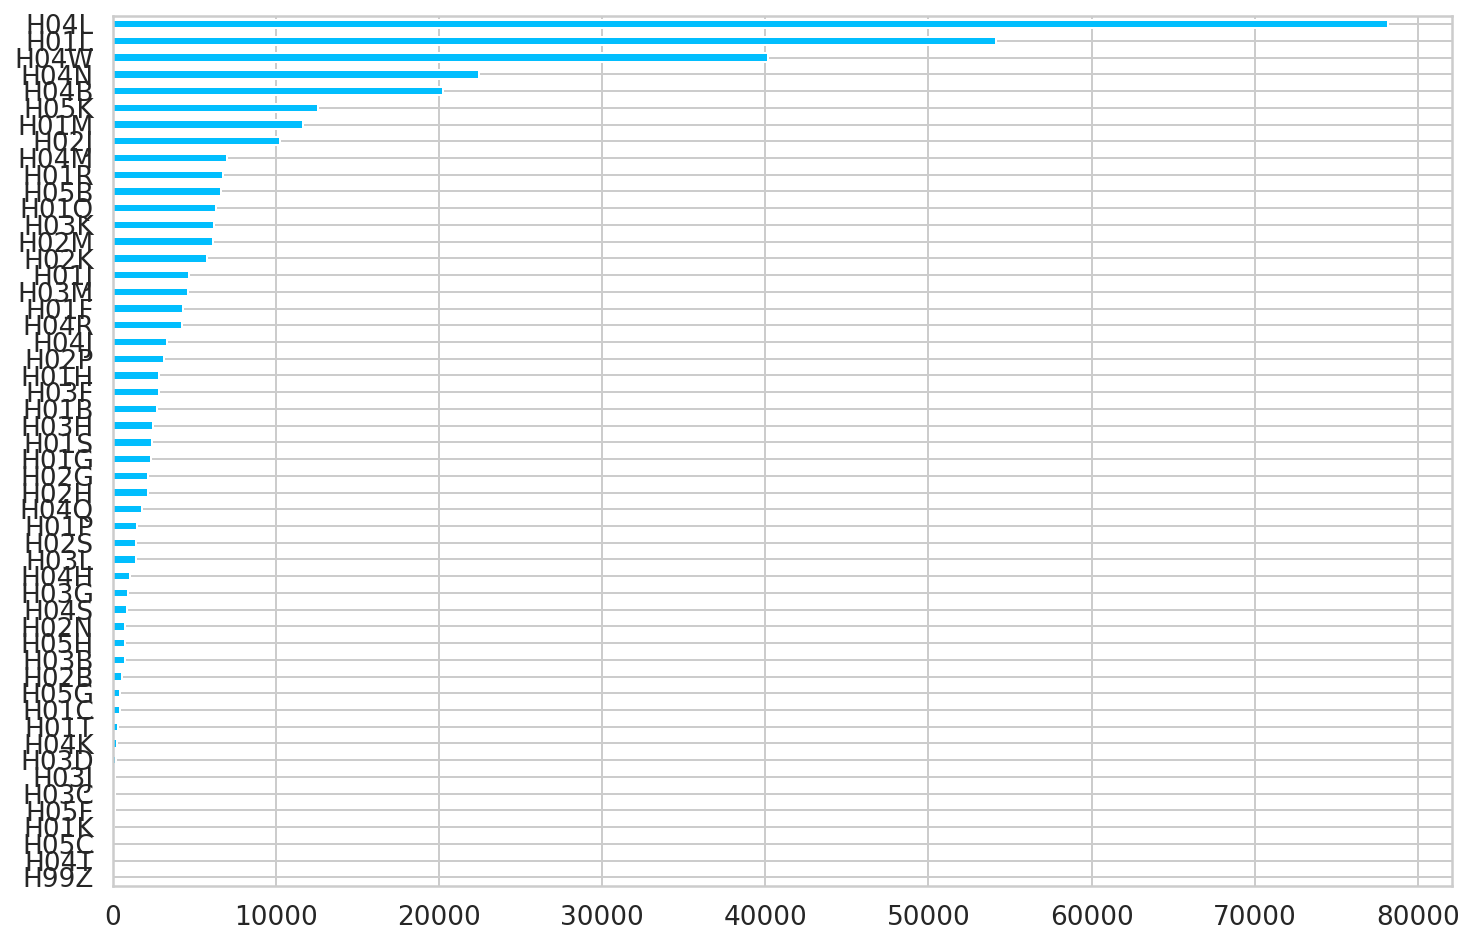

In [ ]:
df.loc[:,'H01B':'H99Z'].sum(axis=0).sort_values().plot(kind='barh')

In [ ]:
pd.DataFrame(df.loc[:,'H01B':'H99Z'].sum(axis=0).sort_values(ascending=False))

,0
H04L,78190
H01L,54145
H04W,40173
H04N,22424
H04B,20251
H05K,12553
H01M,11673
H02J,10222
H04M,6994
H01R,6774


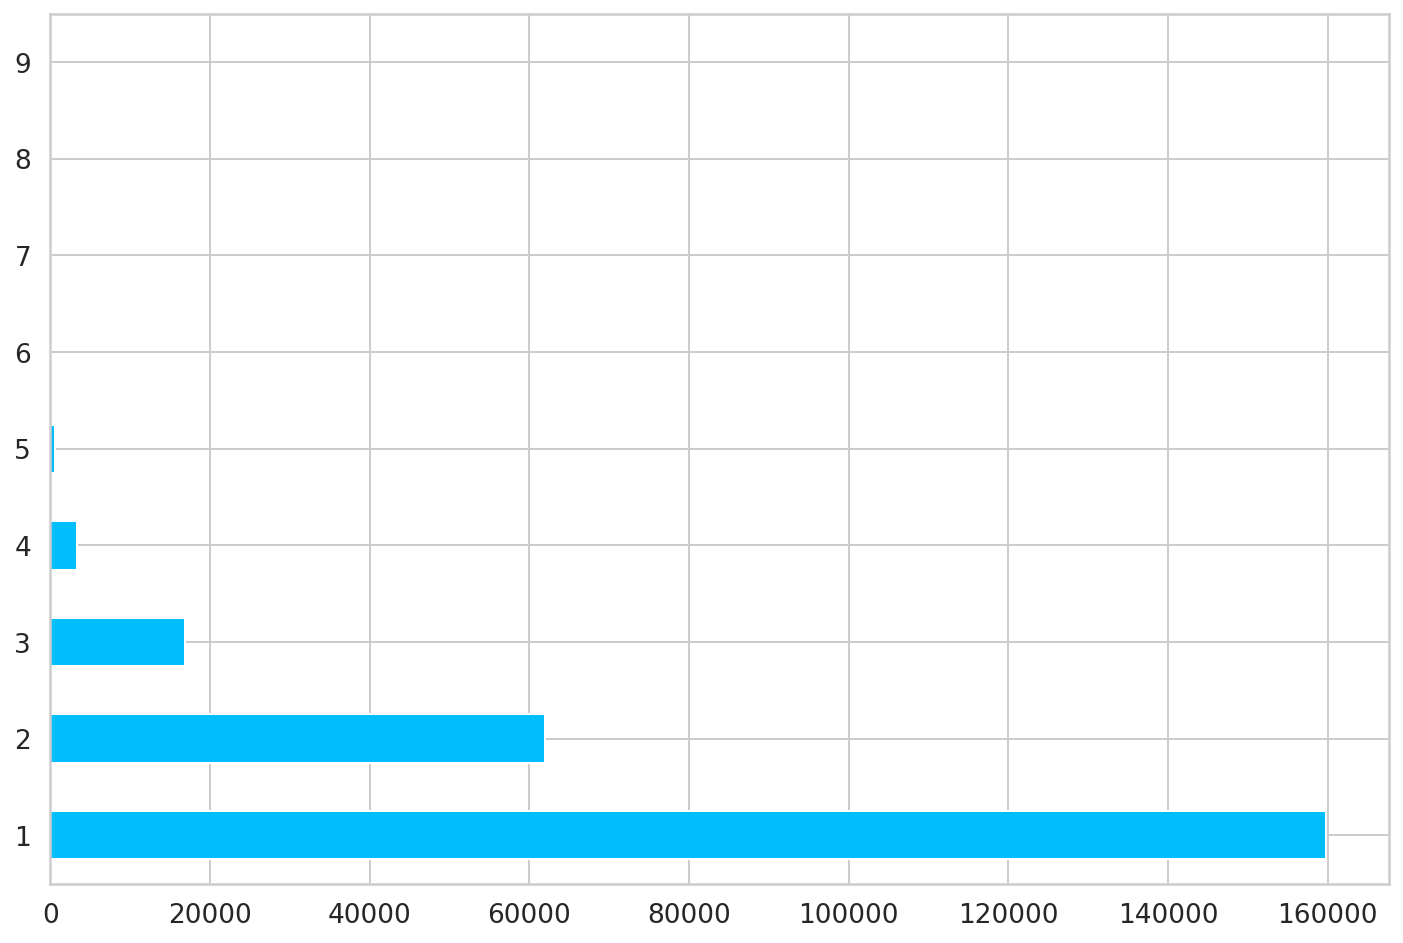

In [ ]:
df.loc[:,'H01B':'H99Z'].sum(axis=1).value_counts().plot(kind='barh')

In [ ]:
df.loc[:,'H01B':'H99Z'].sum(axis=1).value_counts()

1    159738
2     62019
3     16838
4      3421
5       624
6       129
7        57
8        16
9         2
dtype: int64

In [ ]:
for cl in df.loc[:,'H01B':'H99Z'].columns:
  print(df[cl].value_counts()[0] / (df[cl].value_counts()[0] + df[cl].value_counts()[1]))

0.9889558729060631
0.9982251980695426
0.9821902126468021
0.9904259524633098
0.9883546638994581
0.980876612146069
0.9998229315939451
0.7770379338175948
0.9519321045609527
0.9938149593978027
0.9738638796923128
0.9721055492414884
0.9902282947077136
0.9985958063612854
0.9977928217291759
0.9910189257300983
0.9910436329495479
0.9579071337978291
0.9763263658974486
0.9746586285846057
0.9969445405280757
0.9870781242278994
0.9941402711205548
0.9970186621864242
0.9995923308790828
0.9990981864900924
0.9884287855578067
0.9960880235871589
0.9899318080743194
0.9994852662614683
0.9743786134308445
0.9942514536080777
0.9811442736901056
0.9166090164879511
0.9955774077185353
0.9862174894170743
0.9989911218724778
0.6780237518736308
0.9711996178616725
0.9076608851773155
0.9926413664739504
0.9825443494589119
0.9963392136515623
0.9999876463902753
0.8345728121757178
0.9726408723295613
0.999950585561101
0.9995923308790828
0.9981922551102765
0.9970063085766995
0.9483083790416893
0.9999958821300917


In [ ]:
df.loc[:,'H01B':'H99Z'].columns

Index(['H01B', 'H01C', 'H01F', 'H01G', 'H01H', 'H01J', 'H01K', 'H01L', 'H01M',
       'H01P', 'H01Q', 'H01R', 'H01S', 'H01T', 'H02B', 'H02G', 'H02H', 'H02J',
       'H02K', 'H02M', 'H02N', 'H02P', 'H02S', 'H03B', 'H03C', 'H03D', 'H03F',
       'H03G', 'H03H', 'H03J', 'H03K', 'H03L', 'H03M', 'H04B', 'H04H', 'H04J',
       'H04K', 'H04L', 'H04M', 'H04N', 'H04Q', 'H04R', 'H04S', 'H04T', 'H04W',
       'H05B', 'H05C', 'H05F', 'H05G', 'H05H', 'H05K', 'H99Z'],
      dtype='object')

In [ ]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=0) # train,test split
val_df, test_df = train_test_split(val_df, test_size = 0.5, random_state=0)
train_df.shape, val_df.shape, test_df.shape

((194275, 54), (24284, 54), (24285, 54))

# Preprocessing

In [ ]:
LABEL_COLUMNS = df.columns.tolist()[2:] # label 설정
#df[LABEL_COLUMNS].sum().sort_values().plot(kind="barh");

# Tokenization

In [ ]:
BERT_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME) # raw text를 token으로(input) 바꾸기 위해 BertTokenizer 사용

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
MAX_TOKEN_COUNT = 300 

# Dataset

In [ ]:
class ToxicCommentsDataset(Dataset): # 토큰화 프로세스를 PyTorch Dataset으로 요약하고 레이블을 텐서로 변환
  def __init__(
    self,
    data: pd.DataFrame,
    tokenizer: BertTokenizer,
    max_token_len: int = 128
  ):
    self.tokenizer = tokenizer
    self.data = data
    self.max_token_len = max_token_len
  def __len__(self):
    return len(self.data)
  def __getitem__(self, index: int):
    data_row = self.data.iloc[index]
    patent_abstract = data_row.patent_abstract
    labels = data_row[LABEL_COLUMNS]
    encoding = self.tokenizer.encode_plus(
      patent_abstract,
      add_special_tokens=True,
      max_length=self.max_token_len,
      return_token_type_ids=False,
      padding="max_length",
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    return dict(
      patent_abstract=patent_abstract,
      input_ids=encoding["input_ids"].flatten(),
      attention_mask=encoding["attention_mask"].flatten(),
      labels=torch.FloatTensor(labels)
    )

In [ ]:
# larger version of BERT는 더 많은 attention head와 hidden state를 가짐
# custom dataset을 LightningData Module로 정리

class ToxicCommentDataModule(pl.LightningDataModule):
  def __init__(self, train_df, val_df, test_df, tokenizer, batch_size=8, max_token_len=128):
    super().__init__()
    self.batch_size = batch_size
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df
    self.tokenizer = tokenizer
    self.max_token_len = max_token_len
  def setup(self, stage=None):
    self.train_dataset = ToxicCommentsDataset(
      self.train_df,
      self.tokenizer,
      self.max_token_len
    )
    self.val_dataset = ToxicCommentsDataset(
      self.val_df,
      self.tokenizer,
      self.max_token_len
    )
    self.test_dataset = ToxicCommentsDataset(
      self.test_df,
      self.tokenizer,
      self.max_token_len
    )
  def train_dataloader(self):
    return DataLoader(
      self.train_dataset,
      batch_size=self.batch_size,
      shuffle=True,
      num_workers=2
    )
  def val_dataloader(self):
    return DataLoader(
      self.val_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )
  def test_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )

In [ ]:
# ToxicCommentDataModule은 모든 데이터 로딩 로직을 캡슐화하고 필요한 데이터 로더를 반환
# 데이터 모듈의 인스턴스를 생성

N_EPOCHS = 20
BATCH_SIZE = 32 ###
data_module = ToxicCommentDataModule(
  train_df,
  val_df,
  test_df,
  tokenizer,
  batch_size=BATCH_SIZE,
  max_token_len=MAX_TOKEN_COUNT
)

# Model

In [ ]:
# 사전 훈련된 BertModel과 선형 레이어를 사용하여 BERT 표현을 분류 작업으로 변환
# 모든 것을 라이트닝 모듈로 포장
# from torchmetrics.functional import accuracy
class ToxicCommentTagger(pl.LightningModule):
  def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
    super().__init__()
    self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
    self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.n_training_steps = n_training_steps
    self.n_warmup_steps = n_warmup_steps
    #self.criterion = nn.BCELoss()
    #self.criterion = ops.sigmoid_focal_loss()
  def forward(self, input_ids, attention_mask, labels=None):
    output = self.bert(input_ids, attention_mask=attention_mask)
    output = self.classifier(output.pooler_output)
    #output = torch.sigmoid(output)
    loss = 0
    if labels is not None:
        #loss = self.criterion(output, labels, reduction='mean')
        loss = ops.sigmoid_focal_loss(output, labels, reduction='mean')
    return loss, output
  def training_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("train_loss", loss, prog_bar=True, logger=True)
    return {"loss": loss, "predictions": outputs, "labels": labels}
  def validation_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("val_loss", loss, prog_bar=True, logger=True)
    return loss
  def test_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("test_loss", loss, prog_bar=True, logger=True)
    return loss
  def training_epoch_end(self, outputs):
    labels = []
    predictions = []
    for output in outputs:
      for out_labels in output["labels"].detach().cpu():
        labels.append(out_labels)
      for out_predictions in output["predictions"].detach().cpu():
        predictions.append(out_predictions)
    labels = torch.stack(labels).int()
    predictions = torch.stack(predictions)
    for i, name in enumerate(LABEL_COLUMNS):
      class_roc_auc = auroc(predictions[:, i], labels[:, i])
      self.logger.experiment.add_scalar(f"{name}_roc_auc/Train", class_roc_auc, self.current_epoch)
  def configure_optimizers(self):
    optimizer = AdamW(self.parameters(), lr=2e-5)
    scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=self.n_warmup_steps,
      num_training_steps=self.n_training_steps
    )
    return dict(
      optimizer=optimizer,
      lr_scheduler=dict(
        scheduler=scheduler,
        interval='step'
      )
    )

# Optimizer scheduler

In [ ]:
# scheduler의 역할은 학습 중에 optimizer의 학습 속도를 변경하는 것 -> 모델의 더 나은 성능으로 이어질 수 있음
# get_linear_schedule_with_warmup을 사용
# smaple example

dummy_model = nn.Linear(2, 1)
optimizer = AdamW(params=dummy_model.parameters(), lr=0.001)
warmup_steps = 20
total_training_steps = 100
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=warmup_steps,
  num_training_steps=total_training_steps
)
learning_rate_history = []
"""for step in range(total_training_steps):
  optimizer.step()
  scheduler.step()
  learning_rate_history.append(optimizer.param_groups[0]['lr'])
plt.plot(learning_rate_history, label="learning rate")
plt.axvline(x=warmup_steps, color="red", linestyle=(0, (5, 10)), label="warmup end")
plt.legend()
plt.xlabel("Step")
plt.ylabel("Learning rate")
plt.tight_layout();"""

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


'for step in range(total_training_steps):\n  optimizer.step()\n  scheduler.step()\n  learning_rate_history.append(optimizer.param_groups[0][\'lr\'])\nplt.plot(learning_rate_history, label="learning rate")\nplt.axvline(x=warmup_steps, color="red", linestyle=(0, (5, 10)), label="warmup end")\nplt.legend()\nplt.xlabel("Step")\nplt.ylabel("Learning rate")\nplt.tight_layout();'

In [ ]:
# 스케줄러를 사용하기 위해서, training과 warm-up의 수를 계산해야 합니다. 
# The number of training steps per epoch = number of training examples / batch size
# The number of total training steps = training steps per epoch * number of epochs

steps_per_epoch=len(train_df) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS

In [ ]:
warmup_steps = total_training_steps // 5
warmup_steps, total_training_steps

(24284, 121420)

In [ ]:
# 모델 인스턴스 생성!
model = ToxicCommentTagger(
  n_classes=len(LABEL_COLUMNS),
  n_warmup_steps=warmup_steps,
  n_training_steps=total_training_steps
)

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Training

In [ ]:
import os
checkpoint_callback = ModelCheckpoint( # validation loss를 기반으로 최적 모델 저장 및 선정
  dirpath="/content/gdrive/MyDrive/Capstone/checkpoint_focal_loss",
  filename="{epoch}-{train_loss:.4f}-{val_loss:.4f}",
  # every_n_epochs=1,
  save_top_k = -1,
  verbose=True,
  monitor="val_loss",
  mode="min"
)

In [ ]:
logger = TensorBoardLogger("lightning_logs", name="toxic-comments") # tensorboard에 진행상황 기록

In [ ]:
## 모델 학습 시작 !!!
trainer = pl.Trainer(
  logger=logger,
  #checkpoint_callback=cp_callback,
  max_epochs=N_EPOCHS,
  progress_bar_refresh_rate=30,
  gpus=1,
  callbacks=[checkpoint_callback], # early_stopping_callback
  resume_from_checkpoint='/content/gdrive/MyDrive/Capstone/checkpoint_focal_loss/epoch=6-train_loss=0.0006-val_loss=0.0034.ckpt'
  # accelerator= "tpu",
  # devices=8
)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:52: LightningDeprecationWarning: Setting `Trainer(resume_from_checkpoint=)` is deprecated in v1.5 and will be removed in v1.7. Please pass `Trainer.fit(ckpt_path=)` directly instead.
  "Setting `Trainer(resume_from_checkpoint=)` is deprecated in v1.5 and"
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:97: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=30)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU availab

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
trainer.fit(model, data_module) # 2epoch동안만 개선됨.

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:807: LightningDeprecationWarning: `trainer.resume_from_checkpoint` is deprecated in v1.5 and will be removed in v2.0. Specify the fit checkpoint path with `trainer.fit(ckpt_path=)` instead.
  ckpt_path = ckpt_path or self.resume_from_checkpoint
Missing logger folder: lightning_logs/toxic-comments
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: UserWarning: Checkpoint directory /content/gdrive/.shortcut-targets-by-id/14FnxGMYXKN6Ak640rxTEF2EpSTjxSErB/Capstone/checkpoint_focal_loss exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
Restoring states from the checkpoint path at /content/gdrive/MyDrive/Capstone/checkpoint_focal_loss/epoch=6-train_loss=0.0006-val_loss=0.0034.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementat

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:245: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:245: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Training: 6072it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 7, global step 48576: 'val_loss' reached 0.00360 (best 0.00325), saving model to '/content/gdrive/.shortcut-targets-by-id/14FnxGMYXKN6Ak640rxTEF2EpSTjxSErB/Capstone/checkpoint_focal_loss/epoch=7-train_loss=0.0026-val_loss=0.0036.ckpt' as top 8


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 54648: 'val_loss' reached 0.00383 (best 0.00325), saving model to '/content/gdrive/.shortcut-targets-by-id/14FnxGMYXKN6Ak640rxTEF2EpSTjxSErB/Capstone/checkpoint_focal_loss/epoch=8-train_loss=0.0006-val_loss=0.0038.ckpt' as top 9


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 60720: 'val_loss' reached 0.00425 (best 0.00325), saving model to '/content/gdrive/.shortcut-targets-by-id/14FnxGMYXKN6Ak640rxTEF2EpSTjxSErB/Capstone/checkpoint_focal_loss/epoch=9-train_loss=0.0005-val_loss=0.0042.ckpt' as top 10


Validation: 0it [00:00, ?it/s]

Epoch 10, global step 66792: 'val_loss' reached 0.00462 (best 0.00325), saving model to '/content/gdrive/.shortcut-targets-by-id/14FnxGMYXKN6Ak640rxTEF2EpSTjxSErB/Capstone/checkpoint_focal_loss/epoch=10-train_loss=0.0014-val_loss=0.0046.ckpt' as top 11


Validation: 0it [00:00, ?it/s]

Epoch 11, global step 72864: 'val_loss' reached 0.00495 (best 0.00325), saving model to '/content/gdrive/.shortcut-targets-by-id/14FnxGMYXKN6Ak640rxTEF2EpSTjxSErB/Capstone/checkpoint_focal_loss/epoch=11-train_loss=0.0001-val_loss=0.0049.ckpt' as top 12


Validation: 0it [00:00, ?it/s]

Epoch 12, global step 78936: 'val_loss' reached 0.00555 (best 0.00325), saving model to '/content/gdrive/.shortcut-targets-by-id/14FnxGMYXKN6Ak640rxTEF2EpSTjxSErB/Capstone/checkpoint_focal_loss/epoch=12-train_loss=0.0001-val_loss=0.0056.ckpt' as top 13


Validation: 0it [00:00, ?it/s]

Epoch 13, global step 85008: 'val_loss' reached 0.00589 (best 0.00325), saving model to '/content/gdrive/.shortcut-targets-by-id/14FnxGMYXKN6Ak640rxTEF2EpSTjxSErB/Capstone/checkpoint_focal_loss/epoch=13-train_loss=0.0001-val_loss=0.0059.ckpt' as top 14


Validation: 0it [00:00, ?it/s]

Epoch 14, global step 91080: 'val_loss' reached 0.00656 (best 0.00325), saving model to '/content/gdrive/.shortcut-targets-by-id/14FnxGMYXKN6Ak640rxTEF2EpSTjxSErB/Capstone/checkpoint_focal_loss/epoch=14-train_loss=0.0005-val_loss=0.0066.ckpt' as top 15


Validation: 0it [00:00, ?it/s]

Epoch 15, global step 97152: 'val_loss' reached 0.00673 (best 0.00325), saving model to '/content/gdrive/.shortcut-targets-by-id/14FnxGMYXKN6Ak640rxTEF2EpSTjxSErB/Capstone/checkpoint_focal_loss/epoch=15-train_loss=0.0004-val_loss=0.0067.ckpt' as top 16


Validation: 0it [00:00, ?it/s]

Epoch 16, global step 103224: 'val_loss' reached 0.00714 (best 0.00325), saving model to '/content/gdrive/.shortcut-targets-by-id/14FnxGMYXKN6Ak640rxTEF2EpSTjxSErB/Capstone/checkpoint_focal_loss/epoch=16-train_loss=0.0001-val_loss=0.0071.ckpt' as top 17


Validation: 0it [00:00, ?it/s]

Epoch 17, global step 109296: 'val_loss' reached 0.00747 (best 0.00325), saving model to '/content/gdrive/.shortcut-targets-by-id/14FnxGMYXKN6Ak640rxTEF2EpSTjxSErB/Capstone/checkpoint_focal_loss/epoch=17-train_loss=0.0000-val_loss=0.0075.ckpt' as top 18


Validation: 0it [00:00, ?it/s]

Epoch 18, global step 115368: 'val_loss' reached 0.00772 (best 0.00325), saving model to '/content/gdrive/.shortcut-targets-by-id/14FnxGMYXKN6Ak640rxTEF2EpSTjxSErB/Capstone/checkpoint_focal_loss/epoch=18-train_loss=0.0001-val_loss=0.0077.ckpt' as top 19


In [ ]:
trainer.test()

NameError: ignored

# Predictions

In [ ]:
# validation loss에 따른 모델의 best version 확인

trained_model = ToxicCommentTagger.load_from_checkpoint(
  '/content/gdrive/MyDrive/Capstone/checkpoint_sujin/epoch=9-train_loss=0.0097-val_loss=0.0372.ckpt',
  n_classes=len(LABEL_COLUMNS)
)
trained_model.eval()
trained_model.freeze()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
test_comment = "Hi, I'm Meredith and I'm an alch... good at supplier relations"
encoding = tokenizer.encode_plus(
  test_comment,
  add_special_tokens=True,
  max_length=512,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)
_, test_prediction = trained_model(encoding["input_ids"], encoding["attention_mask"])
test_prediction = test_prediction.flatten().numpy()
for label, prediction in zip(LABEL_COLUMNS, test_prediction):
  print(f"{label}: {prediction}")

H01B: 0.010121660307049751
H01C: 0.0014170563081279397
H01F: 0.0016907622339203954
H01G: 0.0012547969818115234
H01H: 0.001069248071871698
H01J: 0.0001237439428223297
H01K: 7.611343608004972e-05
H01L: 0.0064922175370156765
H01M: 0.0516936331987381
H01P: 0.0001039299022522755
H01Q: 0.011934197507798672
H01R: 0.0009599686600267887
H01S: 0.00013148186553735286
H01T: 0.000960728561040014
H02B: 0.01103992946445942
H02G: 0.011460604146122932
H02H: 0.0010235649533569813
H02J: 0.0022264239378273487
H02K: 0.020526306703686714
H02M: 0.0009298708173446357
H02N: 0.0003015495603904128
H02P: 0.003670672420412302
H02S: 0.001762609463185072
H03B: 7.545198604930192e-05
H03C: 9.168946417048573e-05
H03D: 0.00010615155770210549
H03F: 0.0009521848987787962
H03G: 0.00018406780145596713
H03H: 0.00019009677635040134
H03J: 0.00010405862121842802
H03K: 0.00013485871022567153
H03L: 0.0006275569903664291
H03M: 0.002912664320319891
H04B: 0.006429594941437244
H04H: 0.001206045038998127
H04J: 0.0008988737245090306
H0

In [ ]:
THRESHOLD = 0.5
test_comment = "You are such a loser! You'll regret everything you've done to me!"
encoding = tokenizer.encode_plus(
  test_comment,
  add_special_tokens=True,
  max_length=512,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)
_, test_prediction = trained_model(encoding["input_ids"], encoding["attention_mask"])
test_prediction = test_prediction.flatten().numpy()
for label, prediction in zip(LABEL_COLUMNS, test_prediction):
  if prediction < THRESHOLD:
    continue
  print(f"{label}: {prediction}")

H01M: 0.8090310096740723


In [ ]:
# Let’s get a more complete overview of the performance of our model. We’ll start by taking all predictions and labels from the validation set:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = trained_model.to(device)
test_dataset = ToxicCommentsDataset(
  test_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)
predictions = []
labels = []
for item in tqdm(test_dataset):
  _, prediction = trained_model(
    item["input_ids"].unsqueeze(dim=0).to(device),
    item["attention_mask"].unsqueeze(dim=0).to(device)
  )
  predictions.append(prediction.flatten())
  labels.append(item["labels"].int())
predictions = torch.stack(predictions).detach().cpu()
labels = torch.stack(labels).detach().cpu()

  0%|          | 0/24285 [00:00<?, ?it/s]

In [ ]:
accuracy(predictions, labels, threshold=0.5) # 정확도

tensor(0.9890)

## Predictions

In [ ]:
# validation loss에 따른 모델의 best version 확인

trained_model = ToxicCommentTagger.load_from_checkpoint(
  trainer.checkpoint_callback.best_model_path,
  n_classes=len(LABEL_COLUMNS)
)
trained_model.eval()
trained_model.freeze()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
test_comment = "Hi, I'm Meredith and I'm an alch... good at supplier relations"
encoding = tokenizer.encode_plus(
  test_comment,
  add_special_tokens=True,
  max_length=512,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)
_, test_prediction = trained_model(encoding["input_ids"], encoding["attention_mask"])
test_prediction = test_prediction.flatten().numpy()
for label, prediction in zip(LABEL_COLUMNS, test_prediction):
  print(f"{label}: {prediction}")

H01B: 0.012040635570883751
H01C: 0.0005760849453508854
H01F: 0.002016825368627906
H01G: 0.0006104579661041498
H01H: 0.0013296391116455197
H01J: 0.0004924263339489698
H01K: 0.00011160029680468142
H01L: 0.0054897223599255085
H01M: 0.043977584689855576
H01P: 0.00030090080690570176
H01Q: 0.03276745602488518
H01R: 0.0018040265422314405
H01S: 0.00040457057184539735
H01T: 0.00022826909844297916
H02B: 0.0022133453749120235
H02G: 0.005617723800241947
H02H: 0.0006554482970386744
H02J: 0.004511777311563492
H02K: 0.0040978603065013885
H02M: 0.0012336533982306719
H02N: 0.0003427277260925621
H02P: 0.000804908515419811
H02S: 0.0009157385211437941
H03B: 0.00022122435620985925
H03C: 0.00011139094567624852
H03D: 0.00023372453870251775
H03F: 0.0014027199940755963
H03G: 0.0005805519176647067
H03H: 0.0005405608098953962
H03J: 0.00024821850820444524
H03K: 0.0003978330933023244
H03L: 0.0006939178565517068
H03M: 0.001809297944419086
H04B: 0.08841420710086823
H04H: 0.00313085806556046
H04J: 0.00311328121460974

In [ ]:
THRESHOLD = 0.5
test_comment = "You are such a loser! You'll regret everything you've done to me!"
encoding = tokenizer.encode_plus(
  test_comment,
  add_special_tokens=True,
  max_length=512,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)
_, test_prediction = trained_model(encoding["input_ids"], encoding["attention_mask"])
test_prediction = test_prediction.flatten().numpy()
for label, prediction in zip(LABEL_COLUMNS, test_prediction):
  if prediction < THRESHOLD:
    continue
  print(f"{label}: {prediction}")

H01M: 0.7206693291664124


# Evaluation

In [ ]:
# Let’s get a more complete overview of the performance of our model. We’ll start by taking all predictions and labels from the validation set:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = trained_model.to(device)
test_dataset = ToxicCommentsDataset(
  test_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)
predictions = []
labels = []
for item in tqdm(test_dataset):
  _, prediction = trained_model(
    item["input_ids"].unsqueeze(dim=0).to(device),
    item["attention_mask"].unsqueeze(dim=0).to(device)
  )
  predictions.append(prediction.flatten())
  labels.append(item["labels"].int())
predictions = torch.stack(predictions).detach().cpu()
labels = torch.stack(labels).detach().cpu()

  0%|          | 0/24285 [00:00<?, ?it/s]

In [ ]:
accuracy(predictions, labels, threshold=0.5) # 정확도

tensor(0.9893)

In [ ]:
print("AUROC per tag")
for i, name in enumerate(LABEL_COLUMNS):
  tag_auroc = auroc(predictions[:, i], labels[:, i], pos_label=1)
  print(f"{name}: {tag_auroc}") # 결과 매우 좋음

AUROC per tag
H01B: 0.9739715456962585
H01C: 0.9594042897224426
H01F: 0.9758930206298828
H01G: 0.9864568710327148
H01H: 0.9783126711845398
H01J: 0.9779951572418213
H01K: 0.9589123725891113
H01L: 0.987233579158783
H01M: 0.9935047030448914
H01P: 0.9858712553977966
H01Q: 0.9871705174446106
H01R: 0.9862686395645142
H01S: 0.9799949526786804
H01T: 0.9820389747619629
H02B: 0.9864535927772522
H02G: 0.9894669651985168
H02H: 0.982812225818634
H02J: 0.9819592833518982
H02K: 0.9914416074752808
H02M: 0.9868106245994568
H02N: 0.9717136025428772
H02P: 0.9839304089546204
H02S: 0.9867373704910278
H03B: 0.98578941822052
H03C: 0.9463300704956055
H03D: 0.9766193628311157
H03F: 0.98240727186203
H03G: 0.9841886162757874
H03H: 0.9767796993255615
H03J: 0.9670687317848206
H03K: 0.9702883958816528
H03L: 0.9832556247711182
H03M: 0.9708361625671387
H04B: 0.9554699659347534
H04H: 0.9510169625282288
H04J: 0.9732175469398499
H04K: 0.7829474210739136
H04L: 0.9791508316993713
H04M: 0.9412033557891846
H04N: 0.975176334

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)


In [ ]:
y_pred = predictions.numpy() # 결과 꽤 좋음 -> 에포크 별로 돌리지도 않았는데 신기하다..
y_true = labels.numpy()
upper, lower = 1, 0
y_pred = np.where(y_pred > 0.5, upper, lower)
print(classification_report(
  y_true,
  y_pred,
  target_names=LABEL_COLUMNS,
  zero_division=0
))


              precision    recall  f1-score   support

        H01B       0.77      0.51      0.61       286
        H01C       0.94      0.33      0.48        49
        H01F       0.78      0.60      0.68       428
        H01G       0.84      0.61      0.71       252
        H01H       0.73      0.63      0.68       260
        H01J       0.80      0.77      0.79       460
        H01K       0.00      0.00      0.00         9
        H01L       0.92      0.89      0.91      5506
        H01M       0.92      0.87      0.89      1154
        H01P       0.73      0.55      0.63       146
        H01Q       0.87      0.76      0.82       663
        H01R       0.84      0.76      0.80       684
        H01S       0.80      0.61      0.69       215
        H01T       0.93      0.66      0.77        38
        H02B       0.64      0.17      0.26        42
        H02G       0.75      0.56      0.64       196
        H02H       0.67      0.47      0.56       205
        H02J       0.84    

# XAI